# 1. Import packages

In [1]:
import sys
sys.path.append('..')
from modules import tuning, preprocess, tracking, benchmarking, graphics

Invoking __init__.py for modules


# 2. Load dataset

In [17]:
df = preprocess.load_csv_data('../dataset/Occupancy_Estimation.csv')

,Date,Time,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
0,2017/12/22,10:49:41,24.94,24.75,24.56,25.38,121,34,53,40,0.08,0.19,0.06,0.06,390,0.769231,0,0,1
1,2017/12/22,10:50:12,24.94,24.75,24.56,25.44,121,33,53,40,0.93,0.05,0.06,0.06,390,0.646154,0,0,1
2,2017/12/22,10:50:42,25.00,24.75,24.50,25.44,121,34,53,40,0.43,0.11,0.08,0.06,390,0.519231,0,0,1
3,2017/12/22,10:51:13,25.00,24.75,24.56,25.44,121,34,53,40,0.41,0.10,0.10,0.09,390,0.388462,0,0,1
4,2017/12/22,10:51:44,25.00,24.75,24.56,25.44,121,34,54,40,0.18,0.06,0.06,0.06,390,0.253846,0,0,1


In [ ]:
df.head()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10129 entries, 0 to 10128
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  10129 non-null  object 
 1   Time                  10129 non-null  object 
 2   S1_Temp               10129 non-null  float64
 3   S2_Temp               10129 non-null  float64
 4   S3_Temp               10129 non-null  float64
 5   S4_Temp               10129 non-null  float64
 6   S1_Light              10129 non-null  int64  
 7   S2_Light              10129 non-null  int64  
 8   S3_Light              10129 non-null  int64  
 9   S4_Light              10129 non-null  int64  
 10  S1_Sound              10129 non-null  float64
 11  S2_Sound              10129 non-null  float64
 12  S3_Sound              10129 non-null  float64
 13  S4_Sound              10129 non-null  float64
 14  S5_CO2                10129 non-null  int64  
 15  S5_CO2_Slope       

# 3. Data preprocessing
- Step 1: Transform features
  - Binary results for Room_Occupancy_Count
  - Drop Date and Time features
- Step 2: Clean data
  - Drop duplicated rows
  - Detect and apply treatment to outliers

In [4]:
df = preprocess.preprocess_room_occupancy_dataset(df)

The shape of the data set before dropping duplicated:(10129, 17)
The shape of the data set after dropping duplicated:(8828, 17)
Features with outliers:  ['S2_Temp', 'S1_Light', 'S2_Light', 'S3_Light', 'S4_Light', 'S1_Sound', 'S2_Sound', 'S3_Sound', 'S4_Sound', 'S5_CO2', 'S5_CO2_Slope', 'S6_PIR', 'S7_PIR']


,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
0,24.94,24.75,24.56,25.38,35.0,34.0,53.0,40.0,0.080,0.075,0.060,0.06,390.0,0.213462,0.0,0.0,1
1,24.94,24.75,24.56,25.44,35.0,33.0,53.0,40.0,0.095,0.050,0.060,0.06,390.0,0.213462,0.0,0.0,1
2,25.00,24.75,24.50,25.44,35.0,34.0,53.0,40.0,0.095,0.075,0.080,0.06,390.0,0.213462,0.0,0.0,1
3,25.00,24.75,24.56,25.44,35.0,34.0,53.0,40.0,0.095,0.075,0.085,0.09,390.0,0.213462,0.0,0.0,1
4,25.00,24.75,24.56,25.44,35.0,34.0,54.0,40.0,0.095,0.060,0.060,0.06,390.0,0.213462,0.0,0.0,1


In [ ]:
df.head()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8828 entries, 0 to 10128
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   S1_Temp               8828 non-null   float64
 1   S2_Temp               8828 non-null   float64
 2   S3_Temp               8828 non-null   float64
 3   S4_Temp               8828 non-null   float64
 4   S1_Light              8828 non-null   float64
 5   S2_Light              8828 non-null   float64
 6   S3_Light              8828 non-null   float64
 7   S4_Light              8828 non-null   float64
 8   S1_Sound              8828 non-null   float64
 9   S2_Sound              8828 non-null   float64
 10  S3_Sound              8828 non-null   float64
 11  S4_Sound              8828 non-null   float64
 12  S5_CO2                8828 non-null   float64
 13  S5_CO2_Slope          8828 non-null   float64
 14  S6_PIR                8828 non-null   float64
 15  S7_PIR              

<AxesSubplot: >

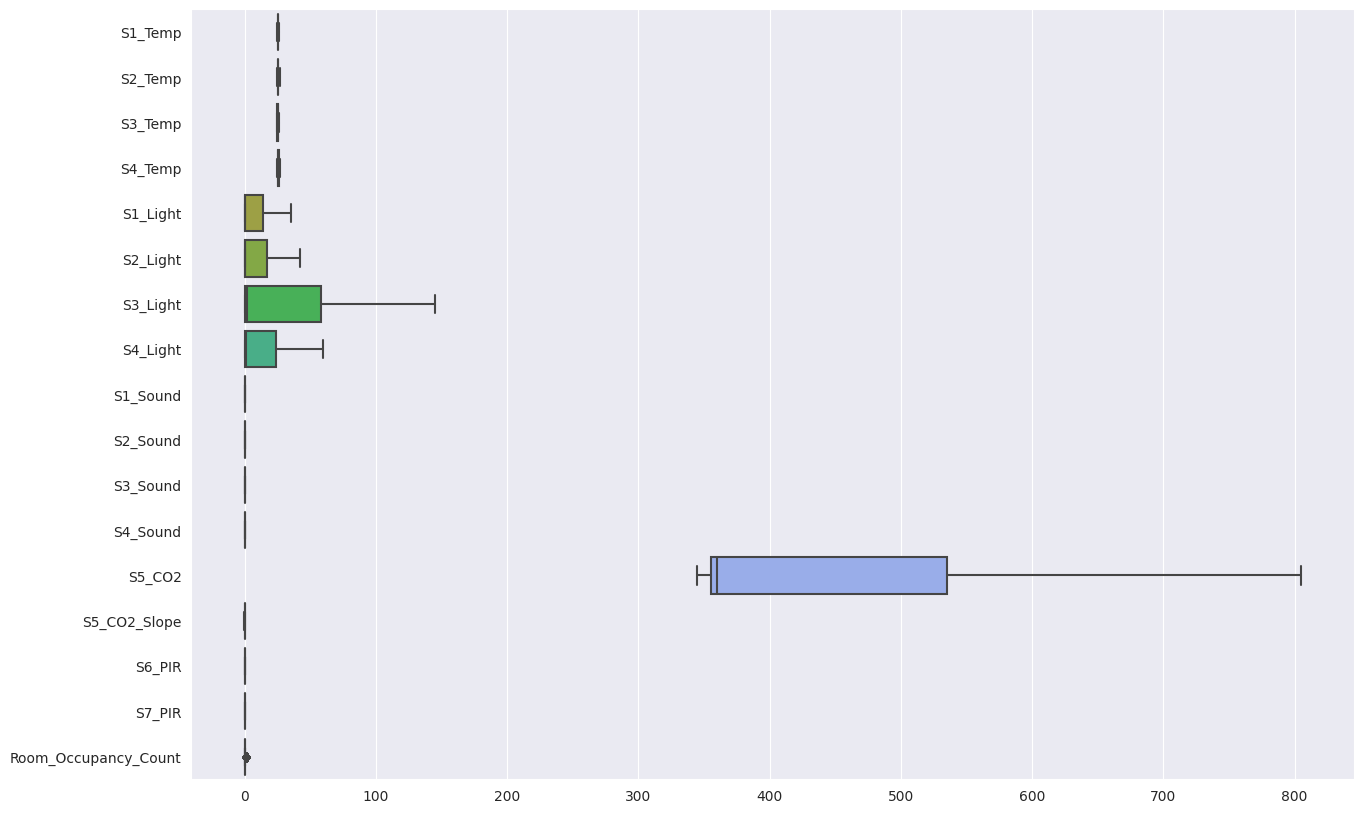

In [6]:
graphics.boxplot_df(df)

# 4. Tuning Hyperparameters: Cross Validation

In [7]:
# Split dataset into features and output
X = preprocess.get_features(df)
y = preprocess.get_output(df)

# Split dataset into training and test
X_train, X_test, y_train, y_test = preprocess.split_dataset(X, y)

## 1. Logistic Regression (LR)

In [8]:
LR_best_estimator = tuning.tuning_with_grid('LR', X_train, y_train, X_test, y_test, 5)

Fitting 5 folds for each of 28 candidates, totalling 140 fits
[CV] END estimator__C=0.001, estimator__penalty=l1, estimator__solver=lbfgs; total time=   0.0s
[CV] END estimator__C=0.001, estimator__penalty=l1, estimator__solver=lbfgs; total time=   0.0s
[CV] END estimator__C=0.001, estimator__penalty=l1, estimator__solver=lbfgs; total time=   0.0s
[CV] END estimator__C=0.001, estimator__penalty=l1, estimator__solver=lbfgs; total time=   0.0s
[CV] END estimator__C=0.001, estimator__penalty=l1, estimator__solver=lbfgs; total time=   0.0s
[CV] END estimator__C=0.001, estimator__penalty=l1, estimator__solver=liblinear; total time=   0.1s
[CV] END estimator__C=0.001, estimator__penalty=l1, estimator__solver=liblinear; total time=   0.0s
[CV] END estimator__C=0.001, estimator__penalty=l1, estimator__solver=liblinear; total time=   0.0s
[CV] END estimator__C=0.001, estimator__penalty=l1, estimator__solver=liblinear; total time=   0.0s
[CV] END estimator__C=0.001, estimator__penalty=l1, estima

/home/misanchz/miniconda3/envs/TFG/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
35 fits failed out of a total of 140.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "/home/misanchz/miniconda3/envs/TFG/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/misanchz/miniconda3/envs/TFG/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/misanchz/miniconda3/envs/TFG/lib/python3.10/site-packages/sklearn/linear_model/_l

## 2. Random Forest (RF)

In [9]:
RF_best_estimator = tuning.tuning_with_randomized('RF', X_train, y_train, X_test, y_test, 5)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END bootstrap=False, max_depth=3, max_features=log2, max_leaf_nodes=6, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END bootstrap=False, max_depth=3, max_features=log2, max_leaf_nodes=6, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END bootstrap=False, max_depth=3, max_features=log2, max_leaf_nodes=6, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, max_depth=3, max_features=log2, max_leaf_nodes=6, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, max_depth=3, max_features=log2, max_leaf_nodes=6, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, max_depth=6, max_features=None, max_leaf_nodes=9, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END b

## 3. Support Vector Machine (SVM)

In [10]:
SVM_best_estimator = tuning.tuning_with_grid('SVM', X_train, y_train, X_test, y_test, 5)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END estimator__C=0.1, estimator__gamma=1, estimator__kernel=rbf; total time=   0.6s
[CV] END estimator__C=0.1, estimator__gamma=1, estimator__kernel=rbf; total time=   0.6s
[CV] END estimator__C=0.1, estimator__gamma=1, estimator__kernel=rbf; total time=   0.6s
[CV] END estimator__C=0.1, estimator__gamma=1, estimator__kernel=rbf; total time=   0.5s
[CV] END estimator__C=0.1, estimator__gamma=1, estimator__kernel=rbf; total time=   0.6s
[CV] END estimator__C=0.1, estimator__gamma=0.1, estimator__kernel=rbf; total time=   0.2s
[CV] END estimator__C=0.1, estimator__gamma=0.1, estimator__kernel=rbf; total time=   0.1s
[CV] END estimator__C=0.1, estimator__gamma=0.1, estimator__kernel=rbf; total time=   0.1s
[CV] END estimator__C=0.1, estimator__gamma=0.1, estimator__kernel=rbf; total time=   0.1s
[CV] END estimator__C=0.1, estimator__gamma=0.1, estimator__kernel=rbf; total time=   0.1s
[CV] END estimator__C=0.1, estimator__

## 4. Multilayer Perceptron (MLP)

In [11]:
MLP_best_estimator = tuning.tuning_with_randomized('MLP', X_train, y_train, X_test, y_test, 5)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END estimator__activation=identity, estimator__alpha=0.05, estimator__hidden_layer_sizes=(100,), estimator__learning_rate=adaptive, estimator__solver=lbfgs; total time=   0.4s
[CV] END estimator__activation=identity, estimator__alpha=0.05, estimator__hidden_layer_sizes=(100,), estimator__learning_rate=adaptive, estimator__solver=lbfgs; total time=   0.3s
[CV] END estimator__activation=identity, estimator__alpha=0.05, estimator__hidden_layer_sizes=(100,), estimator__learning_rate=adaptive, estimator__solver=lbfgs; total time=   0.4s
[CV] END estimator__activation=identity, estimator__alpha=0.05, estimator__hidden_layer_sizes=(100,), estimator__learning_rate=adaptive, estimator__solver=lbfgs; total time=   0.4s
[CV] END estimator__activation=identity, estimator__alpha=0.05, estimator__hidden_layer_sizes=(100,), estimator__learning_rate=adaptive, estimator__solver=lbfgs; total time=   0.5s
[CV] END estimator__activation=log

## Store tuned estimators

In [12]:
# Create list where we are to store the tuned models
estimators_list = []

# Add tuned models inside list
estimators_list.append(LR_best_estimator)
estimators_list.append(RF_best_estimator)
estimators_list.append(SVM_best_estimator)
estimators_list.append(MLP_best_estimator)

# 5. Track training process

## 1. Codecarbon

In [13]:
# Track estimators_list training with codecarbon
tracking.track_benchmarking_codecabon(estimators_list, X_train, y_train)

[codecarbon INFO @ 09:02:25] [setup] RAM Tracking...
[codecarbon INFO @ 09:02:25] [setup] GPU Tracking...
[codecarbon INFO @ 09:02:26] No GPU found.
[codecarbon INFO @ 09:02:26] [setup] CPU Tracking...
[codecarbon WARNING @ 09:02:26] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 09:02:28] CPU Model on constant consumption mode: Intel(R) Core(TM) i5-9400F CPU @ 2.90GHz
[codecarbon INFO @ 09:02:28] >>> Tracker's metadata:
[codecarbon INFO @ 09:02:28]   Platform system: Linux-5.19.0-38-generic-x86_64-with-glibc2.35
[codecarbon INFO @ 09:02:28]   Python version: 3.10.8
[codecarbon INFO @ 09:02:28]   Available RAM : 4.946 GB
[codecarbon INFO @ 09:02:28]   CPU count: 4
[codecarbon INFO @ 09:02:28]   CPU model: Intel(R) Core(TM) i5-9400F CPU @ 2.90GHz
[codecarbon INFO @ 09:02:28]   GPU count: None
[codecarbon INFO @ 09:02:28]   GPU model: None
[codecarbon INFO @ 09:02:31] Energy consumed for RAM : 0.000000 kWh. RAM Power : 1.8548641204833987 W
[codecarbon I

Emissions: 2.436778936178308e-07 kg


[codecarbon INFO @ 09:02:33] CPU Model on constant consumption mode: Intel(R) Core(TM) i5-9400F CPU @ 2.90GHz
[codecarbon INFO @ 09:02:33] >>> Tracker's metadata:
[codecarbon INFO @ 09:02:33]   Platform system: Linux-5.19.0-38-generic-x86_64-with-glibc2.35
[codecarbon INFO @ 09:02:33]   Python version: 3.10.8
[codecarbon INFO @ 09:02:33]   Available RAM : 4.946 GB
[codecarbon INFO @ 09:02:33]   CPU count: 4
[codecarbon INFO @ 09:02:33]   CPU model: Intel(R) Core(TM) i5-9400F CPU @ 2.90GHz
[codecarbon INFO @ 09:02:33]   GPU count: None
[codecarbon INFO @ 09:02:33]   GPU model: None
[codecarbon INFO @ 09:02:36] Energy consumed for RAM : 0.000000 kWh. RAM Power : 1.8548641204833987 W
[codecarbon INFO @ 09:02:36] Energy consumed for all CPUs : 0.000002 kWh. All CPUs Power : 32.5 W
[codecarbon INFO @ 09:02:36] 0.000002 kWh of electricity used since the begining.
[codecarbon INFO @ 09:02:36] [setup] RAM Tracking...
[codecarbon INFO @ 09:02:36] [setup] GPU Tracking...
[codecarbon INFO @ 09:02

Emissions: 3.976192101413214e-07 kg


[codecarbon INFO @ 09:02:38] CPU Model on constant consumption mode: Intel(R) Core(TM) i5-9400F CPU @ 2.90GHz
[codecarbon INFO @ 09:02:38] >>> Tracker's metadata:
[codecarbon INFO @ 09:02:38]   Platform system: Linux-5.19.0-38-generic-x86_64-with-glibc2.35
[codecarbon INFO @ 09:02:38]   Python version: 3.10.8
[codecarbon INFO @ 09:02:38]   Available RAM : 4.946 GB
[codecarbon INFO @ 09:02:38]   CPU count: 4
[codecarbon INFO @ 09:02:38]   CPU model: Intel(R) Core(TM) i5-9400F CPU @ 2.90GHz
[codecarbon INFO @ 09:02:38]   GPU count: None
[codecarbon INFO @ 09:02:38]   GPU model: None
[codecarbon INFO @ 09:02:41] Energy consumed for RAM : 0.000000 kWh. RAM Power : 1.8548641204833987 W
[codecarbon INFO @ 09:02:41] Energy consumed for all CPUs : 0.000001 kWh. All CPUs Power : 32.5 W
[codecarbon INFO @ 09:02:41] 0.000001 kWh of electricity used since the begining.
[codecarbon INFO @ 09:02:41] [setup] RAM Tracking...
[codecarbon INFO @ 09:02:41] [setup] GPU Tracking...
[codecarbon INFO @ 09:02

Emissions: 1.695454053844906e-07 kg


[codecarbon INFO @ 09:02:43] CPU Model on constant consumption mode: Intel(R) Core(TM) i5-9400F CPU @ 2.90GHz
[codecarbon INFO @ 09:02:43] >>> Tracker's metadata:
[codecarbon INFO @ 09:02:43]   Platform system: Linux-5.19.0-38-generic-x86_64-with-glibc2.35
[codecarbon INFO @ 09:02:43]   Python version: 3.10.8
[codecarbon INFO @ 09:02:43]   Available RAM : 4.946 GB
[codecarbon INFO @ 09:02:43]   CPU count: 4
[codecarbon INFO @ 09:02:43]   CPU model: Intel(R) Core(TM) i5-9400F CPU @ 2.90GHz
[codecarbon INFO @ 09:02:43]   GPU count: None
[codecarbon INFO @ 09:02:43]   GPU model: None
[codecarbon INFO @ 09:02:47] Energy consumed for RAM : 0.000000 kWh. RAM Power : 1.8548641204833987 W
[codecarbon INFO @ 09:02:47] Energy consumed for all CPUs : 0.000004 kWh. All CPUs Power : 32.5 W
[codecarbon INFO @ 09:02:47] 0.000004 kWh of electricity used since the begining.


Emissions: 7.933821499837437e-07 kg


## 2. Eco2AI

In [14]:
# Track estimators_list training with eco2ai
tracking.track_benchmarking_eco2ai(estimators_list, X_train, y_train)

/home/misanchz/miniconda3/envs/TFG/lib/python3.10/site-packages/eco2ai/emission_track.py:135: UserWarning: 
If you use a VPN, you may have problems with identifying your country by IP.
It is recommended to disable VPN or
manually install the ISO-Alpha-2 code of your country during initialization of the Tracker() class.
You can find the ISO-Alpha-2 code of your country here: https://www.iban.com/country-codes

  warnings.warn(
/home/misanchz/miniconda3/envs/TFG/lib/python3.10/site-packages/eco2ai/tools/tools_gpu.py:39: NoGPUWarning: 

There is no any available GPU devices or your GPU is not supported by Nvidia library!
The tracker will consider CPU usage only

  warnings.warn(message="\n\nThere is no any available GPU devices or your GPU is not supported by Nvidia library!\nThe tracker will consider CPU usage only\n",
/home/misanchz/miniconda3/envs/TFG/lib/python3.10/site-packages/eco2ai/emission_track.py:135: UserWarning: 
If you use a VPN, you may have problems with identifying your c

# 6. Create benchmarking

In [15]:
benchmarking.create_benchmarking_csv()

In [16]:
df_benchmarking = preprocess.load_csv_data('benchmarking.csv')
df_benchmarking

,Herramientas,Logistic Regression(kWh),Random Forest(kWh),Support Vector Machines(kWh),Multilayer Perceptron(kWh),Eficiencia energetica
0,codecarbon,1.282515e-06,2.092733e-06,8.923442e-07,0.000004,0
1,eco2ai,1.041577e-08,1.011879e-08,1.005836e-08,0.000018,0
